# Financial Sentiment Classification – Project Demo

This notebook provides a high-level overview of our sentiment analysis research project, focused on classifying financial text into **positive**, **neutral**, or **negative** sentiment.

We explore both traditional and modern approaches — from **Logistic Regression** to **FinBERT** and **GPT-4o** — and evaluate each model across diverse financial datasets.

The experiments and detailed code for each model are located in separate notebooks in the `notebooks/` folder.


## 1. Datasets Used

We use four key datasets covering various forms of financial text:

| Dataset      | Description                                                             |
| ------------ | ----------------------------------------------------------------------- |
| Twitter News | Financial tweets labeled as positive/neutral/negative                   |
| FiQA-2018    | Financial text dataset for sentiment and QA.                            |
| PhraseBank   | Expert-labeled financial news sentences labeled for sentiment analysis. |

> Note: FinBERT was trained on PhraseBank, so we exclude it from FinBERT evaluation to avoid data leakage.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, f1_score

df = pd.read_csv("./data/processed/val.csv")
df.head()

,sentence,label,source
0,The negotiations concern personnel of Cencorp ...,neutral,FPB
1,Hedge Funds Are Dumping Ocwen Financial Corpor...,negative,Twitter
2,In 2008 AVC Systemhaus had net sales of EUR 10...,neutral,FPB
3,UPMKymmene is working closely with its shippin...,positive,FPB
4,RBI surprises Street Sensex pares gains after ...,negative,FiQA


## 2. Label Distribution

We check the balance of sentiment labels in the validation set.


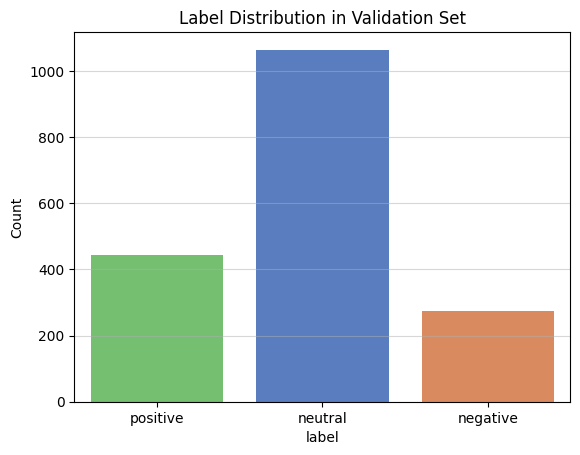

In [ ]:
sns.countplot(
    data=df,
    x="label",
    order=["positive", "neutral", "negative"],
    hue="label",
    palette="muted",
    legend=False,
)
plt.title("Label Distribution in Validation Set")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="-", alpha=0.5)
plt.savefig(
    "./outputs/visualizations/label_distribution.png", dpi=200, bbox_inches="tight"
)
plt.show()

## 3. Dataset Composition

Each sample comes from one of three sources: Twitter, PhraseBank (FPB), or FiQA.

Below is the source distribution of the validation set.


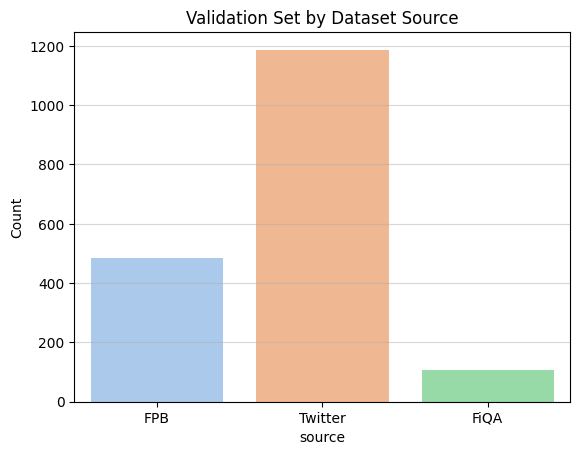

In [ ]:
sns.countplot(data=df, x="source", hue="source", legend=False, palette="pastel")
plt.title("Validation Set by Dataset Source")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="-", alpha=0.5)
plt.show()

In [25]:
df["source"].value_counts()

source
Twitter    1187
FPB         486
FiQA        108
Name: count, dtype: int64

## 4. Sentiment Classification Approaches

We evaluate four distinct modeling strategies for financial sentiment analysis:

| Model               | Category             | Description                                           |
| ------------------- | -------------------- | ----------------------------------------------------- |
| Logistic Regression | Traditional ML       | TF-IDF vectorization with Logistic Regression         |
| FinBERT             | Transformer          | Pretrained transformer fine-tuned on financial text   |
| SpaCy + TextBlob    | Rule-based NLP       | Uses polarity scores from TextBlob (via spaCy plugin) |
| o4-mini (Azure)     | Large Language Model | Zero-shot classification using Azure OpenAI (o4-mini) |

> Each approach is documented in its own notebook in the `notebooks/` directory, with code, training/inference, and evaluation.


## 5. Overall Performance (Macro F1)

The chart below compares macro F1 scores (averaged across all classes) for each model.


In [5]:
lr_preds = []
with open("./models/lr/lr-preds.txt") as f:
    for line in f:
        lr_preds.append(line.strip())

finbert_preds = []
with open("./models/finbert/finbert-preds.txt") as f:
    for line in f:
        finbert_preds.append(line.strip())

gpt4_preds = []
with open("./models/gpt-4.1/gpt-4.1-mini-preds.txt") as f:
    for line in f:
        gpt4_preds.append(line.strip())

gpt4_ft_preds = []
with open("./models/gpt-4.1/gpt-4.1-mini-ft-preds.txt") as f:
    for line in f:
        gpt4_ft_preds.append(line.strip())

o4_preds = []
with open("./models/o4/o4-mini-preds.txt") as f:
    for line in f:
        o4_preds.append(line.strip())

spacy_preds = []
with open("./models/spacy/spacy-custom-preds.txt") as f:
    for line in f:
        spacy_preds.append(line.strip())

In [7]:
true_labels = df["label"].tolist()
no_fpb_labels = df[df["source"] != "FPB"]["label"].tolist()
old_val = pd.read_csv(
    "./data/processed/val_old.csv"
)  # this was the validation dataset before removing sentences with less than 3 words, which the o4-mini model was evaluated on
old_val_labels = old_val["label"].tolist()

f1_scores = {
    "LogReg": f1_score(true_labels, lr_preds, average="macro"),
    "FinBERT": f1_score(no_fpb_labels, finbert_preds, average="macro"),
    "SpaCy": f1_score(true_labels, spacy_preds, average="macro"),
    "GPT-4.1-mini": f1_score(true_labels, gpt4_preds, average="macro"),
    "GPT-4.1-mini-ft": f1_score(true_labels, gpt4_ft_preds, average="macro"),
    "o4-mini": f1_score(old_val_labels, o4_preds, average="macro"),
}

print(
    "Logistic Regression Macro F1:",
    str(round(f1_scores["LogReg"] * 100, 2)) + "%",
)
print(
    "GPT-4.1-mini Macro F1:",
    str(round(f1_scores["GPT-4.1-mini"] * 100, 2)) + "%",
)
print(
    "GPT-4.1-mini-ft Macro F1:",
    str(round(f1_scores["GPT-4.1-mini-ft"] * 100, 2)) + "%",
)
print(
    "SpaCy Macro F1:",
    str(round(f1_scores["SpaCy"] * 100, 2)) + "%",
)
print(
    "FinBERT Macro F1:",
    str(round(f1_scores["FinBERT"] * 100, 2)) + "%",
)
print(
    "o4-mini Macro F1:",
    str(round(f1_scores["o4-mini"] * 100, 2)) + "%",
)

Logistic Regression Macro F1: 70.8%
GPT-4.1-mini Macro F1: 69.24%
GPT-4.1-mini-ft Macro F1: 86.32%
SpaCy Macro F1: 73.62%
FinBERT Macro F1: 63.14%
o4-mini Macro F1: 75.76%


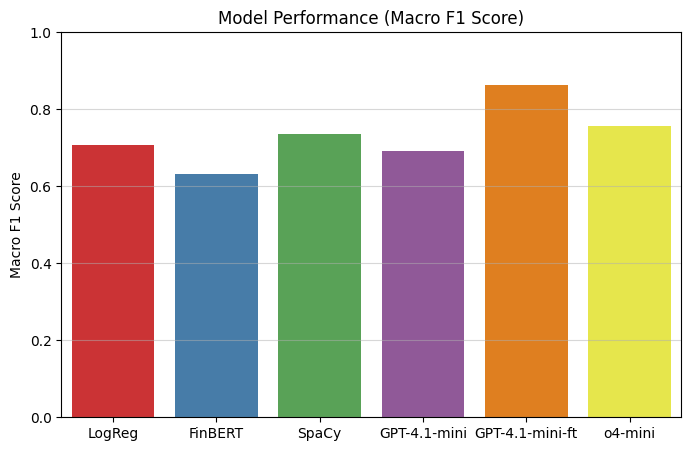

In [18]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=list(f1_scores.keys()),
    y=list(f1_scores.values()),
    hue=list(f1_scores.keys()),
    palette="Set1",
    legend=False,
)
plt.ylim(0, 1)
plt.ylabel("Macro F1 Score")
plt.title("Model Performance (Macro F1 Score)")
plt.grid(axis="y", linestyle="-", alpha=0.5)
plt.savefig(
    "./outputs/visualizations/model_performance.png", dpi=200, bbox_inches="tight"
)
plt.show()

## 6. Confusion Matrix Samples

For full confusion matrix visualizations, refer to:

-   `2_logistic_regression_baseline.ipynb`
-   `3_finbert_inference.ipynb`
-   `4_spacy_textblob.ipynb`
-   `5_o4mini_inference.ipynb`
-   `6_jsonl_conversion.ipynb`
-   `7_fine_tune.ipynb`
-   `8_deploy_4.1minift.ipynb`
-   `9_evaluate_ft.ipynb`
-   `10_evaluate_gpt41mini.ipynb`

Each notebook includes model-specific plots and per-source evaluations.


## 7. Summary

-   o4-mini performs best overall, especially on the Twitter dataset.
-   FinBERT performs well on the Twitter and FiQA datasets.
-   Logistic Regression is surprisingly strong, fast, interpretable, and competitive.
-   Rule-based sentiment (SpaCy + TextBlob) lacks nuance in finance and performs poorly.

This demo serves as an entry point into the codebase. Use the links below to explore deeper:

-   [Data Preprocessing](./notebooks/1_data_preprocessing.ipynb)
-   [Logistic Regression](./notebooks/2_logistic_regression_baseline.ipynb)
-   [FinBERT](./notebooks/3_finbert_inference.ipynb)
-   [SpaCy](./notebooks/4_spacy_textblob.ipynb)
-   [o4-mini](./notebooks/5_o4mini_inference.ipynb)
-   [JSONL Conversion](./notebooks/6_jsonl_conversion.ipynb)
-   [Fine-tuning GPT-4.1-mini](./notebooks/7_fine_tune.ipynb)
-   [Deploying GPT-4.1-mini-ft](./notebooks/8_deploy_4.1minift.ipynb)
-   [Evaluating GPT-4.1-mini-ft](./notebooks/9_evaluate_ft.ipynb)
-   [Evaluating GPT-4.1-mini](./notebooks/10_evaluate_gpt41mini.ipynb)
